## 0.Importar librerias

In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing
from functools import partial
import re
import string
import random
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Adquisicion y Exploracion de datos

### 1. carga de datasets

In [2]:
# Función para cargar el dataset con nombres de columnas personalizados
def load_dataset(file_path):
    return pd.read_csv(file_path, header=None, names=['class', 'text'])

# Cargar los datasets de entrenamiento y prueba
train_df = load_dataset('train.csv')
test_df = load_dataset('test.csv')

# Mostrar las primeras filas y la información básica de los datasets
print("Dataset de entrenamiento:")
train_df.sample(8)


Dataset de entrenamiento:


,class,text
40847,2,I've never had bad food from Four Peaks. The v...
120137,1,"Horrible food, Buffalo sliders tasted like puu..."
335486,2,Easily one of the best places in town! Serving...
221265,1,I wanted to love Canyon Ranch and maybe it was...
318393,1,Nice and pretty hotel and casino.\n\nWe didn't...
544573,1,"This was my first experience in Vegas, & I wis..."
151523,2,I tried this burger for the first time last ni...
515488,1,"Overpriced, small portions. They need to incre..."


### 2. Análisis Exploratorio de Datos (EDA)

In [3]:
def preprocess_text(text):
    # Convertir a minúsculas y eliminar puntuación
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar stop words
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

def perform_eda(df, title):
    print(f"\nEDA para {title}")
    
    # Verificar las columnas disponibles
    print("Columnas disponibles:", df.columns.tolist())
    
    # Distribución de clases
    plt.figure(figsize=(10, 6))
    sns.countplot(x='class', data=df)
    plt.title(f'Distribución de Clases - {title}')
    plt.show()

    # Longitud de los textos
    df['text_length'] = df['text'].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['text_length'], bins=50)
    plt.title(f'Distribución de Longitudes de Textos - {title}')
    plt.xlabel('Longitud de Texto')
    plt.show()

    # Estadísticas básicas de la longitud de los textos
    print("\nEstadísticas de longitud de textos:")
    print(df['text_length'].describe())

    # Correlación entre longitud de texto y clase
    correlation = df['text_length'].corr(df['class'])
    print(f"\nCorrelación entre longitud de texto y clase: {correlation:.4f}")

    # Insights
    print("\nInsights:")
    print("1. Distribución de clases")
    print("2. Distribución de longitudes de textos")
    print("3. Relación entre longitud de texto y clase")



def quick_text_analysis(df, title, sample_size=1000, ngram_range=(1, 2)):
    print(f"\nAnálisis rápido de texto para {title}")
    
    # Tomar una muestra aleatoria de comentarios
    sample_texts = random.sample(df['text'].tolist(), min(sample_size, len(df)))
    
    # Crear un vectorizador para n-gramas
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    
    # Ajustar y transformar los textos de la muestra
    ngrams = vectorizer.fit_transform(sample_texts)
    
    # Obtener los n-gramas más comunes
    sum_words = ngrams.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Mostrar los 20 n-gramas más comunes
    top_ngrams = words_freq[:20]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[x[1] for x in top_ngrams], y=[x[0] for x in top_ngrams])
    plt.title(f'Top 20 N-gramas Más Comunes - {title}\n(Muestra de {sample_size} comentarios)')
    plt.xlabel('Frecuencia')
    plt.ylabel('N-grama')
    plt.show()
    
    # Calcular la cantidad de palabras por texto
    word_counts = [len(text.split()) for text in sample_texts]
    
    # Crear el gráfico de distribución de la cantidad de palabras
    plt.figure(figsize=(12, 6))
    sns.histplot(word_counts, kde=True, bins=30)
    plt.title(f'Distribución de la Cantidad de Palabras por Texto - {title}\n(Muestra de {sample_size} comentarios)')
    plt.xlabel('Cantidad de Palabras')
    plt.ylabel('Frecuencia')
    plt.show()
    
    print("\nInsights:")
    print(f"1. N-gramas más comunes en una muestra de {sample_size} comentarios")
    print("2. Posibles temas o frases recurrentes en los comentarios")
    print(f"3. La longitud promedio de los textos es de {np.mean(word_counts):.2f} palabras")
    print(f"4. La mediana de la longitud de los textos es de {np.median(word_counts):.2f} palabras")
    print(f"5. El texto más corto tiene {min(word_counts)} palabras y el más largo tiene {max(word_counts)} palabras")






Análisis rápido de texto para Dataset de Entrenamiento


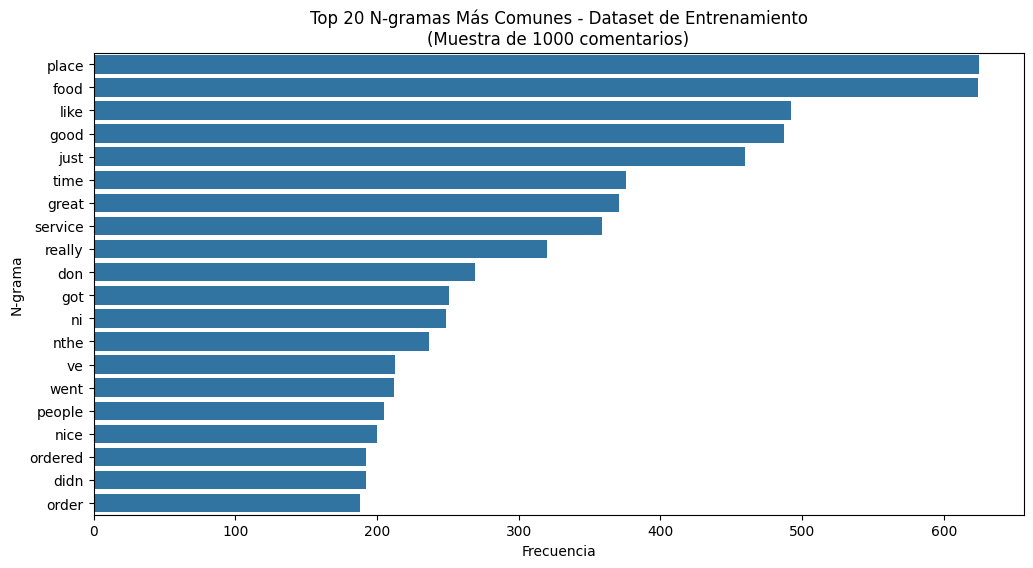

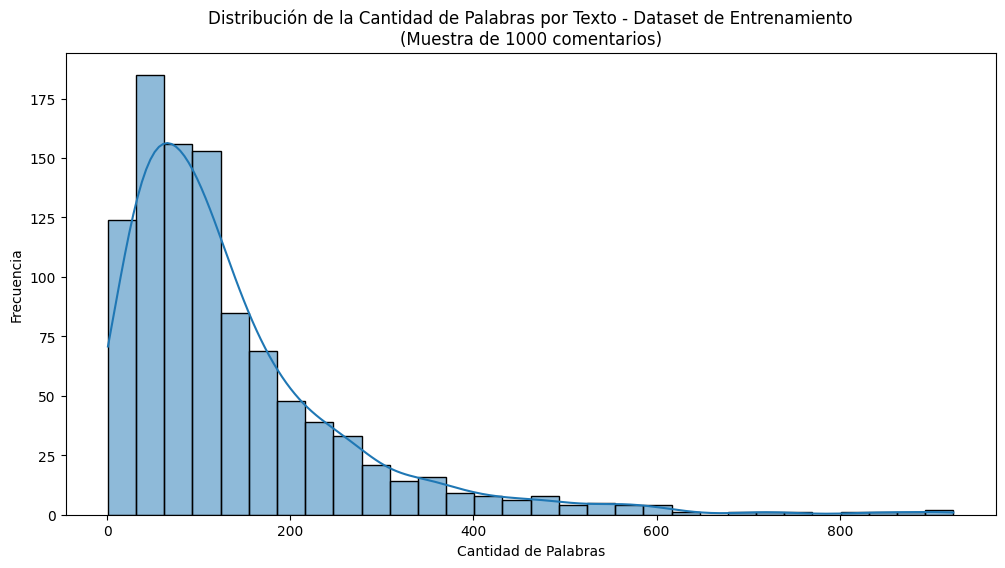


Insights:
1. N-gramas más comunes en una muestra de 1000 comentarios
2. Posibles temas o frases recurrentes en los comentarios
3. La longitud promedio de los textos es de 136.85 palabras
4. La mediana de la longitud de los textos es de 100.00 palabras
5. El texto más corto tiene 1 palabras y el más largo tiene 924 palabras


In [4]:
# Realizar análisis rápido en los datasets de entrenamiento y prueba
quick_text_analysis(train_df, "Dataset de Entrenamiento")


EDA para Dataset de Entrenamiento
Columnas disponibles: ['class', 'text']


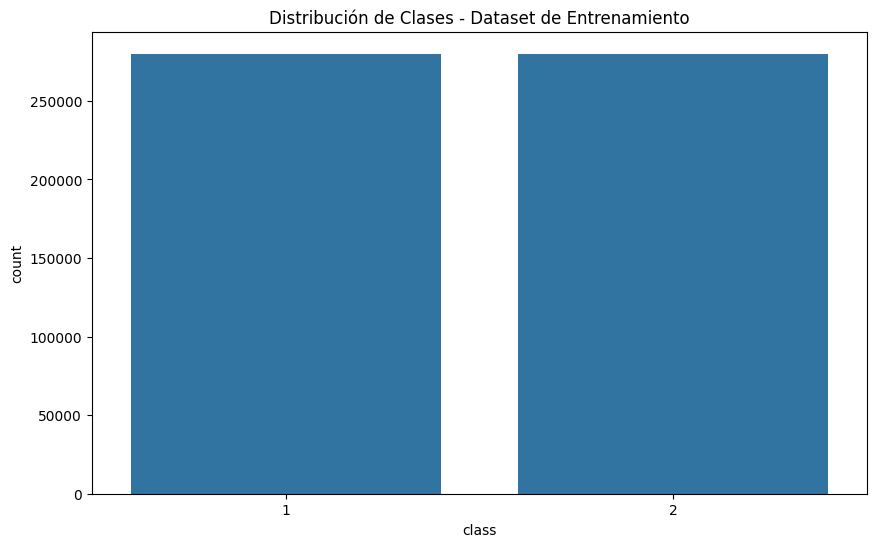

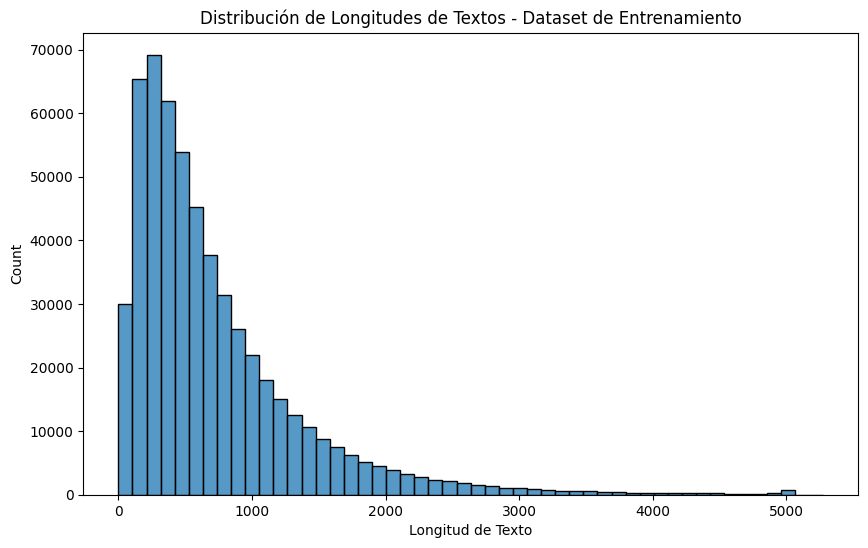


Estadísticas de longitud de textos:
count    560000.000000
mean        725.879430
std         669.001708
min           1.000000
25%         279.000000
50%         528.000000
75%         946.000000
max        5273.000000
Name: text_length, dtype: float64

Correlación entre longitud de texto y clase: -0.1407

Insights:
1. Distribución de clases
2. Distribución de longitudes de textos
3. Relación entre longitud de texto y clase


In [5]:
# Realizar EDA en los datasets de entrenamiento y prueba
perform_eda(train_df, "Dataset de Entrenamiento")


Análisis rápido de texto para Dataset de Prueba


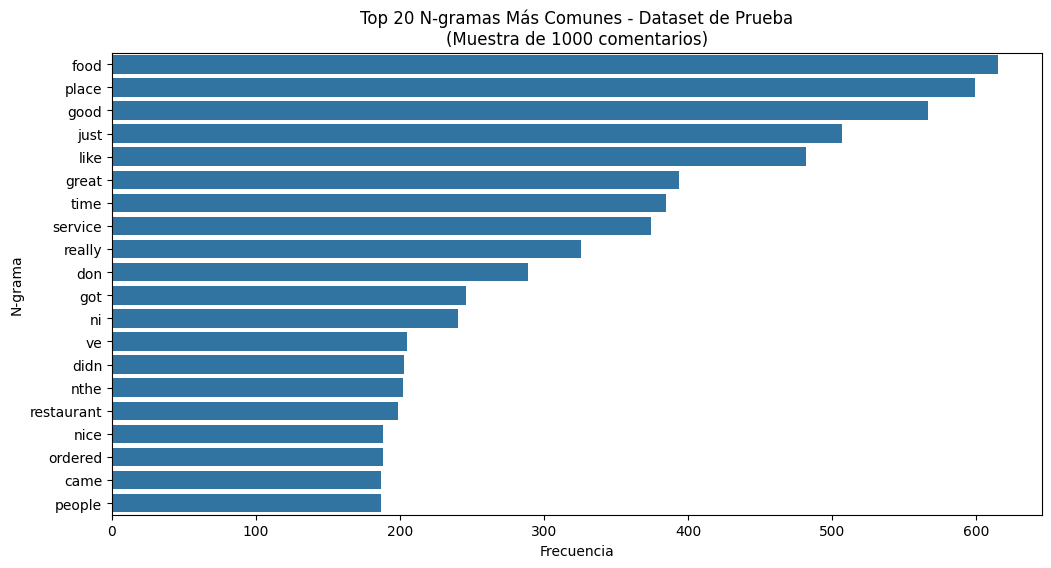

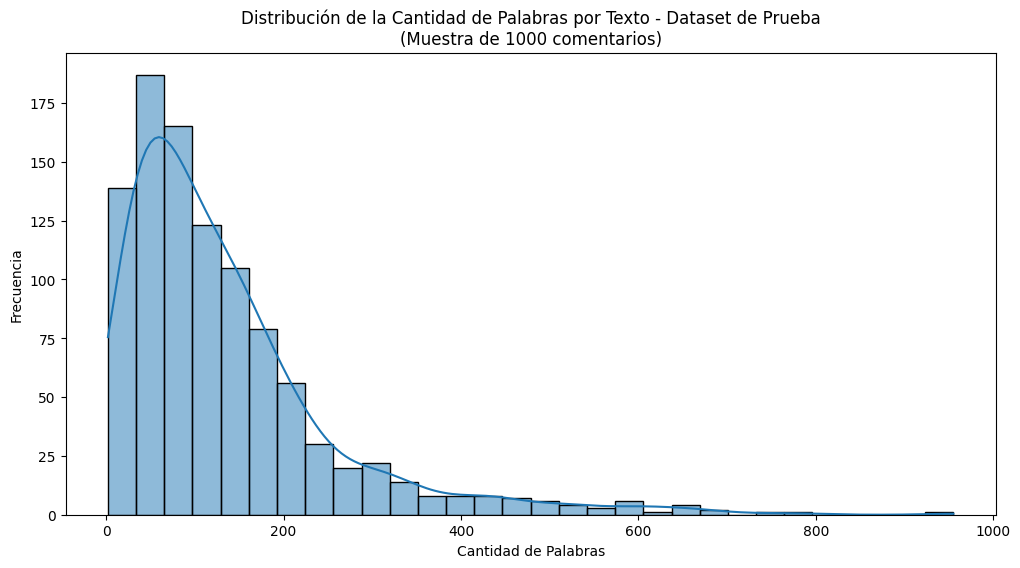


Insights:
1. N-gramas más comunes en una muestra de 1000 comentarios
2. Posibles temas o frases recurrentes en los comentarios
3. La longitud promedio de los textos es de 134.29 palabras
4. La mediana de la longitud de los textos es de 100.00 palabras
5. El texto más corto tiene 2 palabras y el más largo tiene 955 palabras


In [6]:
quick_text_analysis(test_df, "Dataset de Prueba")

## 2. Preprocesamiento de datos

- Definir funcion de preprocesamiento para limpiar los comentarios de signos, stopwords y llevar todo a minusculas.
- En esta version final buscamos una forma de reducir el tiempo de computo que en la version original para ambos dataset llegaba a los 10 minutos.
- Para esto usamos un

In [12]:
%pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.5.0/en_core_web_sm-3.5.0-py3-none-any.whl

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ----------------- ---------------------- 5.5/12.8 MB 30.5 MB/s eta 0:00:01
     --------------------------- ------------ 8.7/12.8 MB 20.7 MB/s eta 0:00:01
     --------------------------------------  12.6/12.8 MB 20.2 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 19.6 MB/s eta 0:00:00
     ---------------------------------------- 0.0/1.2 MB ? eta -:--:--
     --------------------------------- ------ 1.0/1.2 MB 12.5 MB/s eta 0:00:01
     ---------------------------------------- 1.2/1.2 MB 6.3 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [669 lines of output]
        Using cached setuptools-72.1.0-py3-none-any.whl.metadata (6.6 kB)
        Using cached Cython-0.29.37-py2.py3-none-any.whl.metadata (3.1 kB)
        Using cached cymem-2.0.8-cp312-cp312-win_amd64.whl.metadata (8.6 kB)
        Using cached preshed-3.0.9-cp312-cp312-win_amd64.whl.metadata (2.2 kB)
        Using cached murmurhash-1.0.10-cp312-cp312-win_amd64.whl.metadata (2.0 kB)
        Installing build dependencies: started
        Installing build dependencies: finished with status 'done'
        Getting requirements to build wheel: started
        Getting requirements to build wheel: finished with status 'done'
        Preparing metadata (pyproject.toml): started
        Preparing metadata (pyproject.toml): finished with status 'done'
        Using cached numpy-2.0.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
        U

In [14]:
import spacy

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def spacy_preprocess(text):
    doc = nlp(text)
    return " ".join([token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha])

# Aplicar preprocesamiento con SpaCy
train_df['processed_text'] = train_df['text'].apply(spacy_preprocess)
test_df['processed_text'] = test_df['text'].apply(spacy_preprocess)

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
train_df.sample(8)

## 3. Feature Engineering

Este proceso es clave para:
- Convertir las clasificaciones en numeros
- Convertir los feedbacks en numeros definiendo un vocabulario maximo a utlizar de 10.000 palabras mas frecuentes y una longitud maxima de secuencias de 200 posterior a la tokenizacion

In [ ]:
# Codificar las etiquetas
le = LabelEncoder()
train_df['encoded_class'] = le.fit_transform(train_df['class'])
test_df['encoded_class'] = le.transform(test_df['class'])

# Tokenización y padding
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['processed_text'])

X_train = tokenizer.texts_to_sequences(train_df['processed_text'])
X_test = tokenizer.texts_to_sequences(test_df['processed_text'])

X_train_pad = pad_sequences(X_train, maxlen=max_len)
X_test_pad = pad_sequences(X_test, maxlen=max_len)

y_train = train_df['encoded_class'].values
y_test = test_df['encoded_class'].values

print("Forma de los datos de entrenamiento:", X_train_pad.shape)
print("Forma de los datos de prueba:", X_test_pad.shape)

## 4. Desarrollo del modelo inicial